In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import expm

from numerical_methods.Runge_Kutta import RungeKutta_4 as RK

In [2]:
sigma_0 = np.eye(2, dtype=np.complex)
sigma_1 = np.array([[0.j, 1.0],[1.0, 0.0]])
sigma_2 = np.array([[0.j, -1.0j],[1.0j, 0.0]])
sigma_3 = np.array([[1, 0.j],[0, -1]])
sigma_plus = sigma_1 + 1.j*sigma_2
sigma_minus = sigma_1 - 1.j*sigma_2

In [3]:
from functools import reduce

def multiple_kron(arrays):
    """
    Function which return kronecker product of multiple arrays

    :param      arrays: numpy arrays
    :return:    Kronecker product of arrays in input order
    """

    return reduce(np.kron, arrays)[:]

def spin_interaction(n_spins, matrix):
    """

    :param n_spins:     number of spins in the system
    :param matrix:      matrix of interaction
    :return:            function, that produces interaction in spin systems
    """

    def interaction(k, l):
        array = [sigma_0 for i in range(n_spins)]
        array[k] = matrix/2
        array[l] = matrix/2
        return multiple_kron(array)
    return interaction


def Hamiltonian(n_spins, Jz, Jp, hx, hz):
    """

    :param n_spins: number of spins in the system
    :param Jz:      z-coupling
    :param Jp:      xy-coupling
    :param hx:      x_component of local fields
    :param hz:      z_component of local fields
    :return:        Hamiltonian
    """

    spin_x_interaction = spin_interaction(n_spins, sigma_1)
    spin_y_interaction = spin_interaction(n_spins, sigma_2)
    spin_z_interaction = spin_interaction(n_spins, sigma_3)
    H = np.zeros((2**n_spins, 2**n_spins), dtype = np.complex)
    for k in range(n_spins):
        H += Jz*spin_z_interaction(k, k-1) 
        H += Jp*spin_x_interaction(k, k-1)
        H += Jp*spin_y_interaction(k, k-1)
        H += hz[k]*spin_z_interaction(k, k)
        H += hx[k]*spin_x_interaction(k, k)
    return H

def total_Sx(n_spins):
    """

    :param n_spins:     number of spins in the system
    :return: Total      spin along x-axis
    """

    spin_x_interaction = spin_interaction(n_spins, sigma_1)
    Sx = np.zeros((2**n_spins, 2**n_spins), dtype = np.complex)
    for k in range(n_spins):
        Sx += spin_x_interaction(k, k)
    return Sx 

In [10]:
def rhs(hamiltonian, imaginary = False):
    """
    Create right-hand-side for Runge-Kutta method

    :param      hamiltonian: hamiltonian of the sustem
    :param      imaginary: if evolution of the system is imaginary
    :return:    right-hand-side for Runge-Kutta method
    """

    def f(t, rho):
        return -1.j*(hamiltonian@rho - rho@hamiltonian)
    
    
    def f_img(t, rho):
        return -(hamiltonian@rho - rho@hamiltonian)
    
    if imaginary:
        return f_img
    return f

In [11]:
proj_down = np.array([[0.5, 0.5+0.j],[0.5, 0.5]])
proj_up = np.array([[0.5+0.j, -0.5],[-0.5, 0.5]])

def projection(n_spins, matrix):
    """
    Factory of projectors

    :param n_spins:     number of spins in the system
    :param matrix:      observable
    :return:            projection
    """

    def interaction(spin):
        array = [sigma_0 for i in range(n_spins)]
        array[spin] = matrix
        return multiple_kron(array)
    return interaction

def measurement(n_spins, rho, spin):
    """
    Make a measurement
    :param n_spins:     number of spins in the system
    :param rho:         density matrix
    :param spin:        spin number
    :return:            density matrix after measurement
    """

    proj_0 = projection(n_spins, proj_down)(spin)
    proj_1 = projection(n_spins, proj_up)(spin)
    rho = proj_0@rho@proj_0 + proj_1@rho@proj_1
    return rho/np.trace(rho)

In [12]:
def free_induction_decay(n_spins, Jz, Jp, hx, hz, t0, t, dt, n, tau):
    """
    Compute free induction decay with Zeno effect

    :param n_spins: number of spins in the system
    :param Jz:      z-coupling
    :param Jp:      xy-coupling
    :param hx:      x_component of local fields
    :param hz:      z_component of local fields
    :param t0:      initial time
    :param t:       final time
    :param dt:      time step
    :param n:       number of steps
    :param tau:     measurement time steps
    :return:        FID
    """

    S = total_Sx(n_spins)
    hamiltonian = Hamiltonian(n_spins, Jz, Jp, hx, hz)
    func = rhs(hamiltonian) 
    rho = expm(S/10)
    rho /= np.trace(rho)
    N = int(tau*n/t)
    rk = RK.solve(func, t0, rho.copy(), dt, n)
    F = np.zeros(n + 1)
    F[0] = (np.trace(rho@S)).real
    for i in range(n):
        rho = next(rk)
        F[i + 1] = (np.trace(rho@S)).real
        if (i%N == 0 and i != 0):
            spin = np.random.randint(0, n_spins)
            rho = measurement(n_spins, rho, spin)
            rk = RK.solve(func, t0+i*dt, rho.copy(), dt, n)
    return F/F[0]

In [ ]:
def build_plots(tau_list, n_spins = 9, Jz=0.82, Jp=-0.41):
    """
    Build plots for different configurations of experiment

    :param tau_list:    list of measurement time steps
    :param n_spins:     number of spins in the system
    :param Jz:          z-coupling
    :param Jp:          xy-coupling
    :return:            None
    """
    hx = np.zeros(n_spins)
    hz = np.zeros(n_spins)
    t0 = 0
    t = 40
    dt = 0.01
    n = int((t-t0)/dt)
    for tau in tau_list:
        print("Tau = {}".format(tau))
        F = free_induction_decay(n_spins, Jz, Jp, hx, hz, t0, t, dt, n, tau)
        T = np.linspace(t0, t, n+1)
        plt.plot(T, F/F[0], label='Tau = {}'.format(tau))
    plt.xlabel('t')
    plt.ylabel('F(t)')
    plt.legend()
    plt.show()



In [14]:
tau_list = (40, 20, 10, 5)
build_plots(tau_list)

Tau = 40


KeyboardInterrupt: 

Tau = 5
Tau = 3
Tau = 1
Tau = 0.5


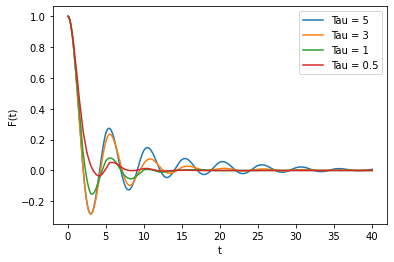

In [47]:
tau_list = (5, 3, 1, 0.5)
build_plots(tau_list)


Tau = 0.5
Tau = 0.25
Tau = 0.1
Tau = 0.05


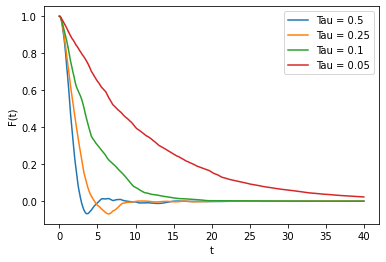

In [48]:
tau_list = (0.5, 0.25, 0.1, 0.05)
build_plots(tau_list)

Tau = 0.05
Tau = 0.04
Tau = 0.03
Tau = 0.02


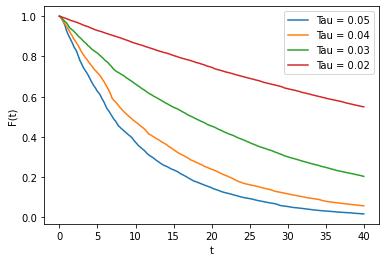

In [50]:
tau_list = (0.05, 0.04, 0.03, 0.02)
build_plots(tau_list)